In [1]:
pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 1.2 MB/s 
     |████████████████████████████████| 45 kB 601 kB/s 
     |████████████████████████████████| 288 kB 9.6 MB/s 
     |████████████████████████████████| 1.1 MB 29.6 MB/s 
     |████████████████████████████████| 112 kB 44.2 MB/s 
     |████████████████████████████████| 271 kB 53.6 MB/s 
     |████████████████████████████████| 144 kB 56.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 


In [2]:
pip install websocket_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 1.5 MB/s 


In [3]:
from binance.client import Client
from binance.enums import *
import time, datetime
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import math
import numpy as np
from functools import reduce

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import sklearn.metrics as metrics

import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
SOCKET = "wss://stream.binance.com:9443/ws/btcusdt@kline_1m"
TRADE_SYMBOL = 'BTCUSDT'
TRADE_SYMBOL_HISTORY = 'BTCUSDT'
API_KEY = 'ziew'
API_SECRET = 'ziew'

In [5]:
client = Client(API_KEY, API_SECRET)#, tld='us')

In [6]:

def GetHistoricalData(howLong):
    howLong = howLong
    # Calculate the timestamps for the binance api function
    untilThisDate = datetime.now()
    # sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
    sinceThisDate = untilThisDate - timedelta(hours = howLong)
    # Execute the query from binance - timestamps must be converted to strings !
    candle = client.get_historical_klines(TRADE_SYMBOL_HISTORY, Client.KLINE_INTERVAL_15MINUTE, str(sinceThisDate), str(untilThisDate))
    # print("TYPE", type(candle),"\n",candle)

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
    # df.set_index('dateTime', inplace=True)

    df["open"] = df.open.astype(float)
    df["high"] = df.high.astype(float)
    df["low"] = df.low.astype(float)
    df["close"] = df.close.astype(float)
    df["volume"] = df.volume.astype(float)

    # Get rid of columns we do not need
    df = df.drop(['quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore','closeTime'], axis=1)

    return df

In [7]:
print("Launching script...")
df=GetHistoricalData(24*20) # TAKE INTO ACCOUNT GMT-2 # 20 days

Launching script...


In [8]:
df

,dateTime,open,high,low,close,volume
0,2022-05-16 23:00:00,30018.45,30044.64,29982.94,30017.88,212.55402
1,2022-05-16 23:15:00,30017.88,30107.85,29950.00,30030.17,312.22602
2,2022-05-16 23:30:00,30030.18,30076.23,29841.34,29902.84,702.89526
3,2022-05-16 23:45:00,29902.85,29913.68,29827.92,29874.01,352.46294
4,2022-05-17 00:00:00,29874.01,29964.88,29807.16,29917.22,402.37920
...,...,...,...,...,...,...
1915,2022-06-05 21:45:00,29926.58,29980.78,29912.45,29965.23,148.61565
1916,2022-06-05 22:00:00,29965.23,30070.83,29944.81,29993.90,782.86095
1917,2022-06-05 22:15:00,29993.91,30037.04,29948.53,29948.54,296.21685
1918,2022-06-05 22:30:00,29948.54,29957.87,29875.01,29945.49,396.46509


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,1920.0,29848.629589,766.026547,28245.87000,29283.105000,29740.06000,30236.595000,32300.96000
high,1920.0,29910.560932,769.222707,28443.19000,29340.000000,29784.26000,30304.465000,32399.00000
low,1920.0,29786.593021,762.995110,28019.56000,29230.027500,29694.07500,30166.890000,32143.93000
close,1920.0,29848.636932,766.022951,28245.88000,29283.095000,29740.06000,30236.595000,32300.96000
volume,1920.0,601.680513,659.314730,52.45715,252.783895,409.85193,685.053047,7033.96025


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dateTime  1920 non-null   object 
 1   open      1920 non-null   float64
 2   high      1920 non-null   float64
 3   low       1920 non-null   float64
 4   close     1920 non-null   float64
 5   volume    1920 non-null   float64
dtypes: float64(5), object(1)
memory usage: 90.1+ KB


In [11]:
#covert datatime column from object dtype to datetime dtype
df["dateTime"] = df.dateTime.astype('datetime64[ns]')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dateTime  1920 non-null   datetime64[ns]
 1   open      1920 non-null   float64       
 2   high      1920 non-null   float64       
 3   low       1920 non-null   float64       
 4   close     1920 non-null   float64       
 5   volume    1920 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 90.1 KB


In [13]:
#Set time column as Index
df.set_index('dateTime',inplace=True)

In [14]:
df.tail()

,open,high,low,close,volume
dateTime,,,,,
2022-06-05 21:45:00,29926.58,29980.78,29912.45,29965.23,148.61565
2022-06-05 22:00:00,29965.23,30070.83,29944.81,29993.90,782.86095
2022-06-05 22:15:00,29993.91,30037.04,29948.53,29948.54,296.21685
2022-06-05 22:30:00,29948.54,29957.87,29875.01,29945.49,396.46509
2022-06-05 22:45:00,29945.49,30059.78,29945.48,30038.59,408.98663


In [36]:

#  Train data 
train = df[:1500].values
# cross validation data
cv = df[1500:1700].values
# Test data 
test = df[1700:].values

In [37]:
print(train.shape,cv.shape,test.shape)

(1500, 5) (200, 5) (220, 5)


In [38]:
test

array([[29506.25   , 29542.11   , 29450.02   , 29493.65   ,   474.01524],
       [29493.65   , 29520.06   , 29401.     , 29463.77   ,   490.37818],
       [29463.76   , 29553.99   , 29448.66   , 29502.22   ,   448.14349],
       ...,
       [29993.91   , 30037.04   , 29948.53   , 29948.54   ,   296.21685],
       [29948.54   , 29957.87   , 29875.01   , 29945.49   ,   396.46509],
       [29945.49   , 30059.78   , 29945.48   , 30038.59   ,   408.98663]])

In [39]:
type(train)

numpy.ndarray

Normalize the data

In [40]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
#scaled_train  = scaler.fit_transform(train)

scaler = scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_cv   = scaler.transform(cv)
scaled_test   = scaler.transform(test)

In [41]:
def data_generator(data,lookback  = 7):
  x = [data[i:(i + lookback)] for i in range(len(data)-lookback)]
  y = [data[i+lookback, 3] for i in range(len(data)-lookback)] # we will take close price as output
  return np.array(x), np.array(y)

In [42]:
trainX, trainY = data_generator(scaled_train)
cvX, cvY = data_generator(scaled_cv)
testX, testY = data_generator(scaled_test)

In [43]:
print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("crossValidationX: ", cvX.shape)
print("crossValidationY: ", cvY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (1493, 7, 5)
trainY:  (1493,)
crossValidationX:  (193, 7, 5)
crossValidationY:  (193,)
testX:  (213, 7, 5)
testY (213,)


In [44]:
# the input to every LSTM layer must be three-dimensional.
model = Sequential()
# input_shape is supposed to be (timesteps, n_features).
model.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))


# output layer
model.add(Dense(units = 1))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 128)            68608     
                                                                 
 dropout_2 (Dropout)         (None, 7, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#checkpoint_path = 'my_best_model.hdf5'
'''
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
'''

earlystopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
ep = 100
BS = 8

callbacks = [earlystopping]
# callbacks = [checkpoint]


history = model.fit(trainX, trainY, batch_size = BS, epochs = ep, verbose=1, shuffle=False, callbacks=callbacks, validation_data=(cvX, cvY)) #, callbacks=callbacks

Epoch 1/100
187/187 [==============================] - 6s 17ms/step - loss: 0.0959 - val_loss: 0.1746
Epoch 2/100
187/187 [==============================] - 2s 13ms/step - loss: 0.0534 - val_loss: 0.1770
Epoch 3/100
187/187 [==============================] - 2s 13ms/step - loss: 0.0487 - val_loss: 0.2789
Epoch 4/100
187/187 [==============================] - 3s 13ms/step - loss: 0.0511 - val_loss: 0.3816
Epoch 5/100
187/187 [==============================] - 3s 14ms/step - loss: 0.0513 - val_loss: 0.4530
Epoch 6/100
187/187 [==============================] - 2s 13ms/step - loss: 0.0520 - val_loss: 0.3343
Epoch 7/100
187/187 [==============================] - 3s 14ms/step - loss: 0.0473 - val_loss: 0.3366
Epoch 8/100
187/187 [==============================] - 3s 14ms/step - loss: 0.0485 - val_loss: 0.3154
Epoch 9/100
187/187 [==============================] - 3s 14ms/step - loss: 0.0522 - val_loss: 0.4436
Epoch 10/100
187/187 [==============================] - 3s 14ms/step - loss: 0.055

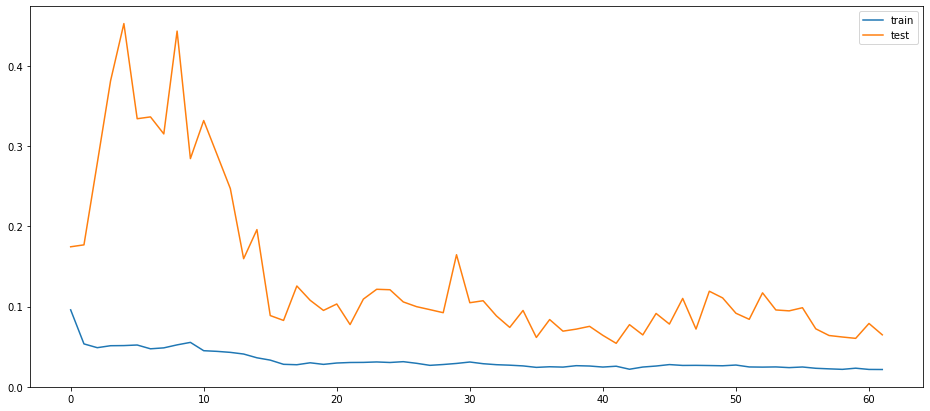

In [47]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

In [48]:
predicted_test_data = model.predict(testX)

In [50]:
def convert_(arr):
  zeros = [ [0]*5 for _ in range(143) ]
  for i in range(len(zeros)):
    try:
      zeros[i][3] = arr[i][0]
    except:
      zeros[i][3] = arr[i]
  return zeros  

In [51]:
predicted_test_data = scaler.inverse_transform(convert_(predicted_test_data))
test_actual = scaler.inverse_transform(convert_(testY))

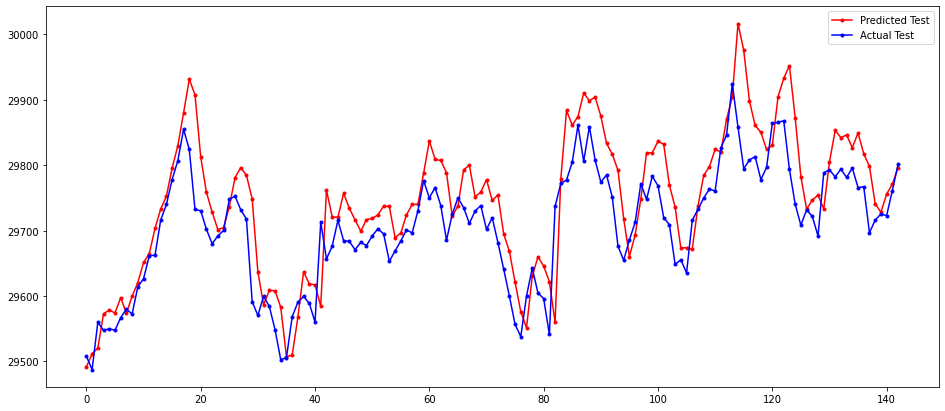

In [52]:
plt.figure(figsize=(16,7))

plt.plot(predicted_test_data[:, [3]], 'r', marker='.', label='Predicted Test')

plt.plot(test_actual[:, [3]], 'b', marker='.', label='Actual Test')

plt.legend()
plt.show()

In [53]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model.predict(trainX)

predicted_btc_price_train_data = scaler.inverse_transform(convert_(predicted_btc_price_train_data))

train_actual = scaler.inverse_transform(convert_(trainY))

In [54]:
# Train Data
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual[:, [3]], predicted_btc_price_train_data[:, [3]]))

print('Test RMSE: %.3f' % rmse_lstm_train)

Test RMSE: 189.094


In [55]:
# Test Data
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual[:, [3]], predicted_test_data[:, [3]]))

print('Test RMSE: %.3f' % rmse_lstm_test)

Test RMSE: 63.504
